# EC-Earth Heatwave Timeseries Generation

In [1]:
# Add Heatwave Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import ERA, Country, utils
import netCDF4

import numpy as np
import pandas as pd

from scipy.ndimage import binary_closing, binary_opening
from scipy.interpolate import griddata

from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import os

In [2]:
DATA_ROOT = os.path.abspath("/Volumes/Samsung_T5/Thesis")
ECE_ROOT = os.path.join(DATA_ROOT, 'EC-Earth')

In [45]:
def plot_T95(T95, year):
    T95_std = T95.mean() + T95.std()

    # Create Big Figure
    plt.rcParams['figure.figsize'] = [15, 5]

    # Plot T95
    plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
    plt.plot(T95[year], c="black", label="T95")
    plt.axhline(T95_std, c="gray", linestyle="--", label="T95 Mean + STD")
    plt.fill_between(T95[year].index, T95_std, T95[year], where=T95[year] > T95_std,
                     interpolate=True, color="crimson", label="Heat Wave Events")

    plt.ylabel("T95 (°C)")
    plt.xlabel("Date")
    plt.xticks(rotation=-90)
    plt.ylim(-3, 3)
    plt.legend()
    plt.tight_layout()
    plt.show()

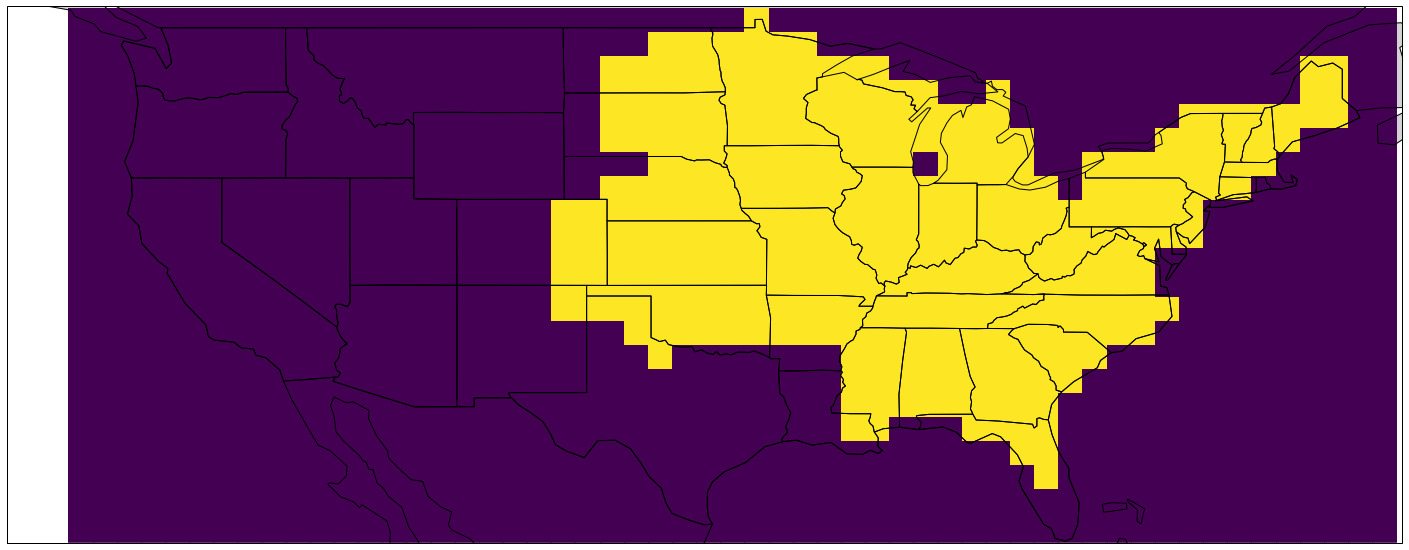

In [33]:
# Create United States Mask
TAS_PATH = os.path.join(ECE_ROOT, 'tas_PD_US/tas_d_ECEarth_PD_s01r00_2035_US.nc')
CLS_PATH = os.path.join(DATA_ROOT, "ERA", "cluster_US.nc")

# Use ERA LandSeaMask to solve for the lack of one in EC-Earth
TAS = ERA(TAS_PATH, 'tas', latitude_key='lat', longitude_key='lon')
CLS = netCDF4.Dataset(CLUSTER_PATH)['mask'][:]

TAS_GRID = utils.era_coordinate_grid(TAS_PATH).reshape(-1, 2)
CLS_GRID = utils.era_coordinate_grid(CLS_PATH).reshape(-1, 2)

CLS_INTERP = griddata(CLS_GRID, CLS.ravel(), TAS_GRID).reshape(TAS.shape[1:]).astype(np.bool)

MASK_US = (utils.era_country_mask(TAS_PATH) == Country.US) * CLS_INTERP

utils.plot_earth("US")
plt.pcolormesh(TAS.longitude, TAS.latitude, MASK_US)
plt.show()

In [41]:
# Load Data for Eastern US cluster from Disk
MAX_SESSION = 16
MAX_REPETITION = 24
YEARS = [2036, 2037, 2038, 2039]

extra_days = 3

TAS = []

for session in range(MAX_SESSION):
    for repetition in range(MAX_REPETITION):
        for i, year in enumerate(YEARS):
            
            year_code = f"{session+1:02d}{repetition*len(YEARS)+i:02d}"
            
            TAS_ = ERA(os.path.join(ECE_ROOT, f'tas_PD_US/tas_d_ECEarth_PD_s{session+1:02d}r{repetition:02d}_{year:04d}_US.nc'),
                       'tas', latitude_key='lat', longitude_key='lon', time_unit='d', time_origin=f'{year}-01-01')
            
            if len(TAS_.time) == 366:
                period = pd.period_range(f"{year_code}-06-{23-extra_days}", f"{year_code}-08-{21+extra_days}")
            else:
                period = pd.period_range(f"{year_code}-06-{24-extra_days}", f"{year_code}-08-{22+extra_days}")
            
            TAS.append(pd.DataFrame(TAS_.data[174-extra_days:234+extra_days, MASK_US], index=period))
            
            print(f"\rLoading {year_code}", end="")

TAS = pd.concat(TAS)

Loading 1695

In [119]:
# T95 is 95th Spatial Percentile of US Summer Anomalies
T95 = TAS.groupby([TAS.index.month, TAS.index.day]).apply(lambda x: x - x.mean()).quantile(0.95, 1)
T95 = (T95 - T95.mean()) / T95.std()
T95_mean = T95.rolling(7, center=True).mean()

# Remove Extra Days from Dataset
T95 = pd.concat([data[extra_days:-extra_days] for year, data in T95.groupby(T95.index.year)])
T95_mean = pd.concat([data[extra_days:-extra_days] for year, data in T95_mean.groupby(T95_mean.index.year)])

T95.to_csv(os.path.join(DATA_ROOT, 'heatwave_ECE.csv'))
T95_mean.to_csv(os.path.join(DATA_ROOT, 'heatwave_ECE_mean.csv'))

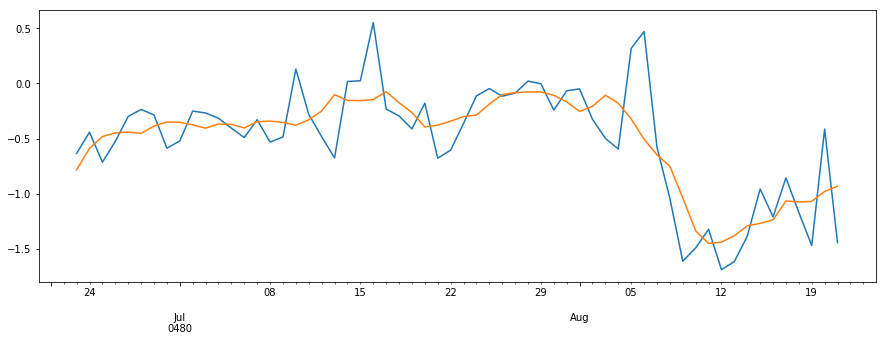

In [121]:
YEAR = 480

T95[T95.index.year == YEAR].plot()
T95_mean[T95.index.year == YEAR].plot()
plt.show()